# Natural language processing - lab 8 (Named entity recognition)
Bartosz Klimza

# Necessary imports

In [19]:
import os
from requests import post, get
import json
import time
from collections import Counter as C
from xml.etree.ElementTree import parse
import matplotlib.pyplot as plt

# 1. Read the classification of Named Entities.
http://clarin-pl.eu/pliki/warsztaty/Wyklad3-inforex-liner2.pdf

# 2. Read the API of NER in Clarin.
http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki

# 3. Read the documentation of CLL format.
http://nlp.pwr.wroc.pl/redmine/projects/corpus2/wiki/CCL_format

# 4. Sort bills according to their size and take top 50 (largest) bills.

In [10]:
files = os.listdir(os.getcwd())
files.sort(key=lambda f: os.stat(f).st_size, reverse=True)
largest_50_files = files[:50]

# 5. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence.

Korzystam z przykładów przedstawionych tutaj: http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki/Python

In [74]:
user = "mojadresemail@email.com"

def upload(file):
    with open(file, "rb") as myfile:
        doc = myfile.read()
    return post("http://ws.clarin-pl.eu/nlprest2/base" + '/upload/', data=doc, headers={'Content-Type': 'binary/octet-stream'})

def process(data):
    doc = json.dumps(data)
    taskid = post("http://ws.clarin-pl.eu/nlprest2/base" + '/startTask/', data=doc, headers={'Content-Type': 'application/json'}).content.decode('utf-8')
    time.sleep(0.2)
    resp = get(url + '/getStatus/' + taskid).json()
    while resp["status"] == "QUEUE" or resp["status"] == "PROCESSING":
        time.sleep(0.5)
        resp = get("http://ws.clarin-pl.eu/nlprest2/base" + '/getStatus/' + taskid).json()
    if resp["status"] == "ERROR":
        print("Error " + data["value"])
        return None
    return resp["value"]


def main(largest):
    global_time = time.time()
    for filename in os.listdir("./ustawy/"):
        if filename in largest:
            filepath = os.path.join("./ustawy/", filename)
            fileid = upload(filepath).content.decode("utf-8")
            data = {'lpmn': "any2txt|wcrft2", 'user': user, 'file': fileid}
            data = process(data)
            if data is None:
                continue
            data = data[0]["fileID"]
            content = get("http://ws.clarin-pl.eu/nlprest2/base" + '/download' + data).content.decode('utf-8')
            with open('out/' + os.path.basename(filename) + '.ccl', "w") as outfile:
                outfile.write(content)

main(largest_50_files)

# 6. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [59]:
tag_str, c_str, a_str, o_str = "tok", "chan", "ann", "orth"

In [28]:
counter = C({})
for f in os.listdir("out/"):
    if str(f)[-4:] == ".ccl":
        files = parse(os.path.join("out/", f)).getroot()
        for file in files:
            for s in file:
                c, upper_letter, e = 0, False, []
                for t in s:
                    if t.tag == tag_str:
                        if t[0].text[0].upper() == t[0].text[0] and t[0].text[0].isalpha():
                            if upper_letter: e[-1] += " " + t[0].text
                            else: e.append(t[0].text)
                            upper_letter = True
                        else: upper_letter = False
                        c += 1
            counter += C(e)
common_50 = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1], reverse=True)[:50]}
common_50

{'Art': 9451,
 'Nr': 8242,
 'W': 4159,
 'Jeżeli': 1915,
 'Dz': 1644,
 'U': 1548,
 'Minister': 1153,
 'Do': 991,
 'Rzeczypospolitej Polskiej': 669,
 'Przepisy': 647,
 'Rozdział': 638,
 'Na': 498,
 'Kto': 448,
 'Prawo': 431,
 'Przepis': 429,
 'Kodeksu': 393,
 'Organ': 390,
 'Policji': 384,
 'Sąd': 288,
 'Skarbu Państwa': 287,
 'Unii Europejskiej': 287,
 'Nie': 277,
 'Za': 276,
 'Pozostałe': 275,
 'Rada Ministrów': 266,
 'Z': 261,
 'Straży Granicznej': 253,
 'Minister Sprawiedliwości': 239,
 'O': 232,
 'I': 220,
 'Prezes Rady Ministrów': 219,
 'Państwowej Straży Pożarnej': 219,
 'Zmiany': 212,
 'Przy': 208,
 'II': 188,
 'Po': 185,
 'Wniosek': 184,
 'Kasy Chorych': 175,
 'Inne': 168,
 'Od': 165,
 'Azot': 165,
 'Koszty': 162,
 'Minister Obrony Narodowej': 162,
 'Minister Finansów': 155,
 'III': 155,
 'Rady': 144,
 'Tkaniny': 140,
 'Osoby': 137,
 'Zakład': 133,
 'Przepisu': 128}

# 7. Apply the NER algorithm to identify the named entities in the same set of documents (not lemmatized) using the n82 model.

Ponownie korzystam z przykładów przedstawionych tutaj: http://nlp.pwr.wroc.pl/redmine/projects/nlprest2/wiki/Python

In [4]:
# Z uwagi na bardzo długi czas wykonania wygenerowałem połowę plików 

user = "mojadresemail@email.com"

def upload(file):
    with open(file, "rb") as myfile:
        doc = myfile.read()
    return post("http://ws.clarin-pl.eu/nlprest2/base" + '/upload/', data=doc, headers={'Content-Type': 'binary/octet-stream'})

def process(data):
    doc = json.dumps(data)
    taskid = post(url + '/startTask/', data=doc, headers={'Content-Type': 'application/json'}).content.decode('utf-8')
    time.sleep(0.2)
    resp = get(url + '/getStatus/' + taskid).json()
    while resp["status"] == "QUEUE" or resp["status"] == "PROCESSING":
        time.sleep(0.5)
        resp = get("http://ws.clarin-pl.eu/nlprest2/base" + '/getStatus/' + taskid).json()
    if resp["status"] == "ERROR":
        print("Error " + data["value"])
        return None
    return resp["value"]

def new_main(largest):
    global_time = time.time()
    for filename in os.listdir("./ustawy/"):
        if filename in largest:
            filepath = os.path.join("./ustawy/", filename)
            fileid = upload(filepath).content.decode("utf-8")
            data = {'lpmn': 'any2txt|wcrft2|liner2({"model":"n82"})', 'user': user, 'file': fileid}
            data = process(data)
            if data is None:
                continue
            data = data[0]["fileID"]
            content = get("http://ws.clarin-pl.eu/nlprest2/base" + '/download' + data).content.decode('utf-8')
            with open('new_out/' + os.path.basename(filename) + '.ccl', "w") as outfile:
                outfile.write(content)

new_main(largest_50_files)

# 8. Plot the frequency (histogram) of the coarse-grained classes (e.g. nam_adj, nam_eve, nam_fac).

In [70]:
r, cg_class = dict(), dict()
for f in os.listdir('new_out/'):
    if str(f)[-4:] == ".ccl":
        files = parse(os.path.join('new_out/', f)).getroot()
        for file in files:
            for s in file:
                stat, e = {}, ""
                for t in s:
                    if t.tag == tag_str:
                        for a in t.findall(a_str):
                            if int(a.text) != 0:
                                ak, w = (a.get(c_str), a.text), t.find(o_str).text
                                v = stat.get(ak, [])
                                v.append(w)
                                stat[ak] = v
                for a, ex in stat.items():
                    e, name = " ".join(ex), a[0]
                    val = r.get((name, e), 0)
                    r[(name, e)] = val + 1             
for k, v in r.items():
    cg_class["_".join(k[0].split("_")[0:2])] = cg_class.get("_".join(k[0].split("_")[0:2]), 0) + v

In [71]:
sorted(cg_class.items(), key = lambda kv: -kv[1])

[('nam_org', 3905),
 ('nam_pro', 1478),
 ('nam_loc', 638),
 ('nam_liv', 308),
 ('nam_oth', 200),
 ('nam_adj', 104),
 ('nam_fac', 36),
 ('nam_num', 14),
 ('nam_eve', 11)]

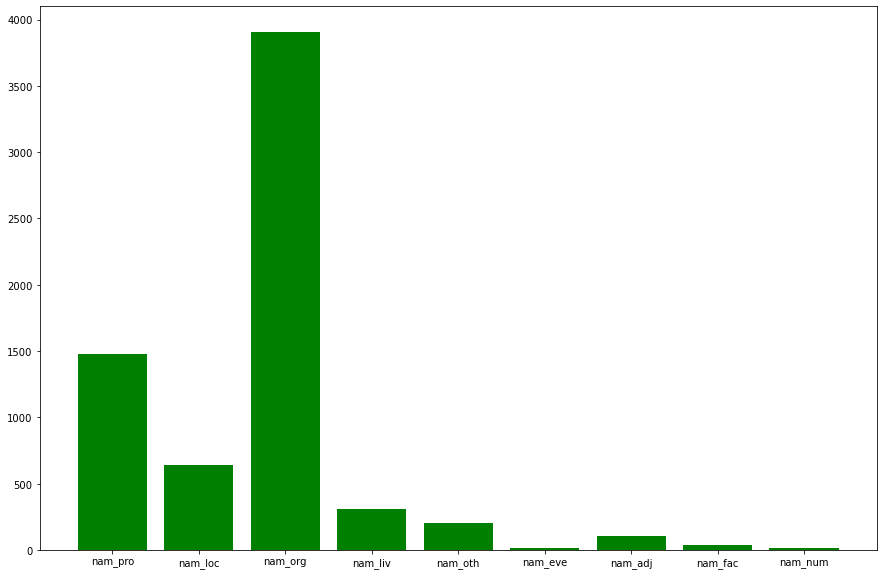

In [72]:
plt.figure(figsize=(15, 10))
plt.bar(cg_class.keys(), cg_class.values(), align='center', color="green")
plt.show()

# 10. Display 50 most frequent Named Entities including their count and fine-grained type.

In [18]:
print(sorted(result.items(), key = lambda kv: -kv[1])[:50])

[(('nam_pro_media_periodic', 'Dz . U .'), 699), (('nam_loc_gpe_country', 'Rzeczypospolitej Polskiej'), 364), (('nam_org_organization', 'Unii Europejskiej'), 161), (('nam_oth_currency', 'zł'), 139), (('nam_org_institution', 'Skarbu Państwa'), 126), (('nam_org_institution', 'Urząd Patentowy'), 104), (('nam_org_organization', 'Państwowej Straży Pożarnej'), 100), (('nam_org_institution', 'Rada Ministrów'), 98), (('nam_org_organization', 'EFTA'), 96), (('nam_org_company', 'Europejskiego Porozumienia o Wolnym Handlu'), 85), (('nam_org_institution', 'Minister Sprawiedliwości'), 78), (('nam_org_institution', 'Prezes Rady Ministrów'), 66), (('nam_org_organization', 'Wspólnoty Europejskiej'), 56), (('nam_pro_media_periodic', 'Dz . Urz'), 52), (('nam_pro_title_document', 'Kodeksu karnego'), 51), (('nam_liv_person', 'Kasa Chorych'), 51), (('nam_org_institution', 'Minister Zdrowia i Opieki Społecznej'), 49), (('nam_org_institution', 'Skarb Państwa'), 48), (('nam_org_institution', 'Prezes Urzędu'), 